## Set up

First we import the necessary packages. We also decide which device (cpu/gpu) to use for training.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt

#You can choose other gpu cores by changing the number 0 to other valid numbers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test Environment

The following block defines the training environment. You can specify the lenght of the state $n$ and the number of agents $m$ you want. 

When initialized, each agent gets a unique goal with each position equally likely to be 0 or 1. The starting position for each agent is initialized in the same way. So every position is toally random.

At each timestep, each agent decides it's action. Action $a$ must be in $\{0, 2, ..., n-1\}$ and the $a^{th}$ position in state will change.

Whenever an agent's state equals to it's goal, it finishes an episode and both state and goal will be initialized again. Otherwise, if this episode has continued $50n$ timesteps, it will restart automatically with a different random state and goal.

In [2]:
class environment_info:
    def __init__(self, num_agents, length):
        self.vector_observations = np.zeros((num_agents, length))
        self.rewards = np.zeros((num_agents, 1))
        self.local_done = [False] * num_agents
        
    def reset(self):
        num_agents, length = self.vector_observations.shape
        self.vector_observations = np.array(np.random.random_sample((num_agents, length))<0.5, dtype=float)
        self.rewards = np.zeros((num_agents, 1))
        self.local_done = [False] * num_agents

class test_environment:
    def __init__(self, num_agents, length):
        '''
        num_agents and length should be integers.
        goal is a numpy array of shape (num_agents, length)
        '''
        self.num_agents = num_agents
        self.length = length
        self.goal = np.array(np.array(np.random.random_sample((num_agents, length))<0.5, dtype=float))#A random goal
        self.env_info = environment_info(num_agents, length)
        self.steps = np.zeros((num_agents, 1))#record how many steps has each agent taken
    
    def set_goal(self, goal):
        '''if you want to change the goal'''
        if goal.shape == self.goal.shape:
            self.goal = goal
        else:
            print('Goal size incorrect, rejected')
            
    def reward(self):
        '''This function calculates the reward for current state (or the previous action)'''
        if self.goal is None:
            return np.zeros((self.num_agents, 1))
        current = self.env_info.vector_observations
        goal = self.goal
        difference = np.sum((current-goal)**2, axis=1, keepdims= True)
        rewards = np.where(difference==0, 1, -0.1)
        return rewards
      
    def step(self, actions):
        '''
        actions should be a 1-d list or numpy array with length equal to number of agents
        
        DO NOT use shape (num_agents, 1)!!!
        
        the values of corresponding positions will change from 1 to 0 or 0 to 1
        each element in actions should be in range(length)
        '''
        #Find the next state
        actions = actions.reshape(self.num_agents)#just in case
        
        state = self.env_info.vector_observations
        state[range(self.num_agents), actions] -= 1
        state = np.abs(state)
        self.steps += np.ones((self.num_agents, 1))
        self.env_info.vector_observations = state
        
        #Get reward signal
        self.env_info.rewards = self.reward()
        
        #See if agents are 'done'
        self.env_info.local_done = (self.env_info.rewards == 1) | (self.steps == 50*self.length)
        dones = self.env_info.local_done.copy()
        dones = dones.reshape(-1)
        done_count = sum(dones)
        
        #reset the agents that are done
        self.steps[dones] = 0
        self.env_info.vector_observations[dones, :] = np.array(np.random.random_sample((done_count, self.length))<0.5, dtype=float)
        self.goal[dones, :] = np.array(np.random.random_sample((done_count, self.length))<0.5, dtype=float)
        
        return self.env_info
    
    def reset(self):
        self.env_info.reset()
        self.steps = np.zeros((self.num_agents, 1))
        return self.env_info
        
    def get_state(self):
        '''lazy way to get state info'''
        return self.env_info.vector_observations

## Network

The following defines the Q-network used in training. Now it's constraint to be a sequential model with 3 hidden layers. You can choose the size of each hidden layer as well as the use of batchnormalization. The state_size and action_size must be set according to the environment.

A dueling structure is also supported in Duel_QNetwork class.

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=None, BatchNorm=False):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        if fc_units is None:
            fc_units = [256, 128, 64]
        self.fc1=nn.Linear(2*state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.bn1 = nn.BatchNorm1d(fc_units[0])
        self.bn2 = nn.BatchNorm1d(fc_units[1])
        self.bn3 = nn.BatchNorm1d(fc_units[2])
        self.BatchNorm = BatchNorm

    def forward(self, state, goal):
        """Build a network that maps state -> action values."""
        x = torch.cat([state, goal], dim=1)
        if self.BatchNorm:
            x=self.bn1(F.relu(self.fc1(x)))
            x=self.bn2(F.relu(self.fc2(x)))
            x=self.bn3(F.relu(self.fc3(x)))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
        x=self.fc4(x)
        return(x)
        
class Duel_QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed,fc_units=None, BatchNorm=False):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Duel_QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        if fc_units is None:
            fc_units = [256, 128, 64]
        self.fc1=nn.Linear(2*state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.fc5=nn.Linear(fc_units[2],1)
        self.bn1 = nn.BatchNorm1d(fc_units[0])
        self.bn2 = nn.BatchNorm1d(fc_units[1])
        self.bn3 = nn.BatchNorm1d(fc_units[2])
        self.BatchNorm = BatchNorm
        
    def forward(self, state, goal):
        """Build a network that maps state -> action values."""
        x = torch.cat([state, goal], dim=1)
        if self.BatchNorm:
            x=self.bn1(F.relu(self.fc1(x)))
            x=self.bn2(F.relu(self.fc2(x)))
            x=self.bn3(F.relu(self.fc3(x)))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
        x1=self.fc4(x)
        x2=self.fc5(x)
        return(x1+x2)

## Replay Buffer

This block defines a replay buffer. It also supports sampling experience with a priority/prior probability for prioritized Q Learning.

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "goal", "action", "reward", "next_state", "next_goal", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, goal, action, reward, next_state, next_goal, done):
        """Add a new experience to memory."""
        e = self.experience(state, goal, action, reward, next_state, next_goal, done)
        self.memory.append(e)
    
    def sample(self,priority,alpha):
        """Randomly sample a batch of experiences from memory.
        
        Params
        ======
            priority: a vector records the priority for each experience
            alpha: to determine how much the priority should influence the probability. 
                p(sample i) ~ priority(sample i)**alpha
        """
        #Sample experiences with priority. First sample index, then pick corresponding experience
        prob=np.array(priority)**alpha
        prob=prob/np.sum(prob)#This makes it a probability
        index=np.random.choice(a=len(prob),size=self.batch_size,replace=False,p=prob)
        experiences = list(map(self.memory.__getitem__,index))
        
        #Extract information from memory unit and return
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        goals = torch.from_numpy(np.vstack([e.goal for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        next_goals = torch.from_numpy(np.vstack([e.next_goal for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, goals, actions, rewards, next_states, next_goals, dones), index

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Hindsight Experience Replay

In [5]:
class Hindsight:
    ''' 
    This is a class for hindsight experience replay 
    By default one instance of this class only serves one agent. If multiple agent exist, create multiple instances
    '''
    def __init__(self, N, alpha):
        '''
        N(int) is the smallest number of timesteps required to generate new experience.
        N is at least 10.
        If no enough experiences collected, nothing will be created
        alpha(float) is propotion to be set to positive, it must be between (0.1, 0.3)
        '''
        self.reset()
        self.N = max(N, 10)
        self.alpha = max(0.1, min(0.2, alpha))
        
    def add(self, state, goal, action, next_state, next_goal):
        self.states.append(state)
        self.goals.append(goal)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.next_goals.append(next_goal)
        
    def reward(self, states, goals):
        ''' 
        This reward function is only for this task. 
        Here done is the original information from the same timestep
        '''
        states = np.array(states)
        goals = np.array(goals)
        rewards = np.where(np.sum((states-goals)**2, axis=1, keepdims=True)==0, 1, -0.1)
        dones = rewards==1
        return rewards, dones
    
    def to_memory(self, memory):
        '''
        This part process data and save them into a format that can be directly transfered into agent memory
        The basic idea is to select some special timestep and set them as new goals
        So that in the generated data the positive/negative data will have some stable ratio
        memory is the target memory. It must has .add() method
        
        IMPORTANT:
        This procedure requires the history comes from a single episode without any reset of environment
        '''
        total_length = len(self.states)
        if total_length<self.N:
            return None
        
        M = int(self.alpha*total_length)
        #idx contains the timesteps that goals will be changed to next_state, the first one cannot be chosen
        idx = random.sample(range(1, total_length-1), M-1)#In next step, the last one is forced to be chosen
        idx = [0] + idx + [total_length-1]
        idx = np.sort(idx)
        
        #After having the 'success' index, we change goals accordingly 
        self.goals[0] = self.next_states[idx[1]].copy()
        self.next_goals[0] = self.next_states[idx[1]].copy()
        for i in range(1,len(idx)):
            for j in range(idx[i-1]+1, idx[i]):
                self.goals[j] = self.next_states[idx[i]].copy()
                self.next_goals[j] = self.next_states[idx[i]].copy()
            self.goals[idx[i]] = self.next_states[idx[i]].copy()
        
        rewards, dones = self.reward(self.next_states, self.goals)
        
        for state, goal, action, reward, next_state, next_goal, done in zip(self.states, self.goals, self.actions, rewards, self.next_states, self.next_goals, dones):
            memory.add(state, goal, action, reward, next_state, next_goal, done)
        
    def reset(self):
        self.states = []
        self.goals = []
        self.actions = []
        self.next_states = []
        self.next_goals = []

## DQN Agent

The next block defines the agent class. Some hyperparameters are defined at the very beginning and some others are passes into the agent as parameters.

Here is the list of parameters:

  * size of replay buffer
  * batch size for learning
  * $\gamma$ the weight decay of future rewards
  * $\tau$ the soft update parameter
  * learning rate
  * update frequency
  * default priority for experience
  * $\alpha$ the exponential parameter for priority. Check [this paper](https://arxiv.org/abs/1511.05952) for more details
  * environment in which the agent is trained
  * whether to use prioritized Q Learning
  * whether to use duel structure
  * hidden units for Q Network
  * whether to use BatchNorm

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
DEFAULT_PRIORITY=1e-2   # initialization value for priority

class DQN_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, env, state_size, action_size, seed, prioritized=False, Duel=False, alpha=0, learning_rate=LR, gamma=GAMMA, tau=TAU, fc_units=None, BatchNorm=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            lr (float): learning rate for local network
            tau (float): learning rate for target network
            gamma (float): decay rate for future rewards
            prioritized (bollean): decide whether to use prioritized Q-Learning
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.lr=learning_rate
        self.tau=tau
        self.gamma=gamma
        self.prioritized=prioritized
        self.env = env
        
        # Q-Network
        if Duel:
            self.qnetwork_local = Duel_QNetwork(state_size, action_size, seed, fc_units=fc_units, BatchNorm=BatchNorm).to(device)
            self.qnetwork_target = Duel_QNetwork(state_size, action_size, seed, fc_units=fc_units, BatchNorm=BatchNorm).to(device)
        else:
            self.qnetwork_local = QNetwork(state_size, action_size, seed, fc_units=fc_units, BatchNorm=BatchNorm).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, seed, fc_units=fc_units, BatchNorm=BatchNorm).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.priority=deque(maxlen=BUFFER_SIZE)
        if self.prioritized:
            self.alpha=alpha
        else:
            self.alpha=0# The default value is 0, which is the not prioritized case
            
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def act(self, state, goal, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).to(device)
        goal = torch.tensor(goal, dtype=torch.float32).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state, goal)
        self.qnetwork_local.train()

        if random.random() > eps:
            actions = np.argmax(action_values.detach().cpu().numpy(), axis=1)
        else:
            actions = np.random.choice(a=range(self.action_size), size=self.env.num_agents)
        return actions

    def learn(self, experiences, index, gamma):
        
        states, goals, actions, rewards, next_states, next_goals, dones= experiences

        self.optimizer.zero_grad()
        loss=0
        ## TODO: find the correct way to calculate the weights to make the update unbiased.
        ## Should: each experience times 1/(NP_i) to correct the bias introduced by P_i
        ## In the paper: 1/(NP_i)^beta. And normalize the weights so that the largest one is 1 (Not used here)
        
        # ------------------- calculate the weights ------------------- #
        ## If it's prioritized DQN, calculate the weights, otherwise, use 1
        if self.prioritized:
            w=np.array(self.priority)**self.alpha
            w=w/np.sum(w)
            w=w[index]
            w=1/(len(agent.memory)*w)
            w=torch.from_numpy(w)
        else:
            w=torch.ones(BATCH_SIZE)
        
        # ------------------- calculate the update  ------------------- #
        self.qnetwork_target.train()
        expected_rewards = self.qnetwork_local(states, goals)
        expected_rewards = expected_rewards[range(expected_rewards.shape[0]), actions.cpu().numpy().reshape(-1)].view(-1,1)
        expected_next_rewards = self.qnetwork_target(next_states, next_goals)
        expected_next_rewards, _ = torch.max(expected_next_rewards,1,keepdim=True)
        real_rewards = rewards + self.gamma*(1-dones)*expected_next_rewards
        w=w.float().view(-1,1)
        loss=torch.sum(w*(expected_rewards-real_rewards)**2)/BATCH_SIZE
        loss.backward()
        self.optimizer.step()
        self.qnetwork_target.eval()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
        
        # -------------------    update priority    ------------------- #
        ## Only update when the method is prioritized DQN
        if self.prioritized:
            priority=np.array(self.priority)
            values=abs((expected_rewards-real_rewards).detach().numpy())
            priority[index]=np.where(values>DEFAULT_PRIORITY,values,DEFAULT_PRIORITY)
            self.priority=deque(priority,maxlen=BUFFER_SIZE)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Training

The next block defines the procedure to train an agent. You can decide the following parameters:

    * number of episode
    * the length of each episode
    * $\epsilon$, the probability of choosing actions randomly, at the very beginning
    * $\epsilon$'s decay per episode
    * $\epsilon$'s minimum value
    * whether to use hindsight experience replay

In [7]:
def dqn(n_episode=1000, max_t=1000, eps_start=1, eps_end=0.01, eps_decay=0.99, HER=True):
    
    scores_window = deque(maxlen=100)
    eps = eps_start
    means = []
    for i_episode in range(1, n_episode+1):
        episodic_scores = []
        scores = np.zeros((env.num_agents, 1))
        env_info = env.reset()
        if HER:
            hindsights = [Hindsight(N=20, alpha=0.2) for _ in range(env.num_agents)]
        states = env_info.vector_observations.copy()
        goals = env.goal.copy()
        for t in range(max_t):
            actions = agent.act(states, goals, eps)
            env_info = env.step(actions)
            next_states = env_info.vector_observations.copy()
            next_goals = env.goal.copy()
            rewards = env_info.rewards.copy()
            dones = env_info.local_done.copy()
            for j in range(env.num_agents):
                agent.memory.add(states[j], goals[j], actions[j], rewards[j], next_states[j], next_goals[j], dones[j])
                agent.priority.append(DEFAULT_PRIORITY)
                if HER:
                    hindsights[j].add(states[j], goals[j], actions[j], next_states[j], next_goals[j])
                        
            agent.t_step = (agent.t_step + 1) % UPDATE_EVERY
            if agent.t_step == 0:
                # If enough samples are available in memory, get random subset and learn
                if len(agent.memory) > BATCH_SIZE:
                    experience, index = agent.memory.sample(agent.priority, agent.alpha)
                    agent.learn(experience, index, GAMMA)
            states = next_states.copy()
            goals = next_goals.copy()
            scores += rewards.copy()
                
            for j in range(env.num_agents):
                if dones[j]:
                    episodic_scores.append(scores[j].copy())
                    scores[j] = 0
                    if HER:
                        count = len(hindsights[j].states)
                        hindsights[j].to_memory(agent.memory)
                        hindsights[j].reset()
                        if count>=hindsights[j].N:
                            for _ in  range(count):
                                agent.priority.append(DEFAULT_PRIORITY)
        if HER:                        
            for j in range(env.num_agents):
                count = len(hindsights[j].states)
                hindsights[j].to_memory(agent.memory)
                hindsights[j].reset()
                if count>=hindsights[j].N:
                    for _ in  range(count):
                        agent.priority.append(DEFAULT_PRIORITY)
                    
        means.append(np.mean(episodic_scores))
        scores_window.append(np.mean(episodic_scores))
        eps = max(eps_decay*eps, eps_end)
        print('\rEpisode {}, Score {:.4f}\tAverage Score: {:.4f}'.format(i_episode, means[-1], np.mean(scores_window),), end="")        
        if i_episode % 50 == 0:
            print(' ')
            
    return means

## Experiments

We test the performance of different agents (have HER or not, use BatchNorm or not, in total 4) with various state length. We start with $n=5$

In [8]:
env = test_environment(10, 5)
env.goal

array([[1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.]])

Episode 50, Score 0.3267	Average Score: -0.4768 
Episode 100, Score 0.6693	Average Score: 0.0261 
Episode 150, Score 0.7580	Average Score: 0.6200 
Episode 200, Score 0.7909	Average Score: 0.7445 
Episode 250, Score 0.8165	Average Score: 0.7922 


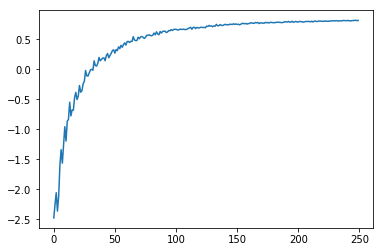

In [9]:
#This is the result with BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[64]*3, BatchNorm=True)
means = dqn(n_episode=250, HER=True)
plt.plot(means)
plt.show()

Episode 50, Score 0.2897	Average Score: -0.5362 
Episode 100, Score 0.6540	Average Score: -0.0007 
Episode 150, Score 0.7617	Average Score: 0.6243 
Episode 200, Score 0.8020	Average Score: 0.7459 
Episode 250, Score 0.8143	Average Score: 0.7922 


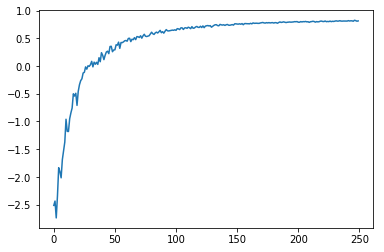

In [10]:
#This is the result with BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[64]*3, BatchNorm=True)
means = dqn(n_episode=250, HER=False)
plt.plot(means)
plt.show()

Episode 50, Score 0.3595	Average Score: -0.5029 
Episode 100, Score 0.6578	Average Score: 0.0153 
Episode 150, Score 0.7496	Average Score: 0.6220 
Episode 200, Score 0.7972	Average Score: 0.7439 
Episode 250, Score 0.8140	Average Score: 0.7918 


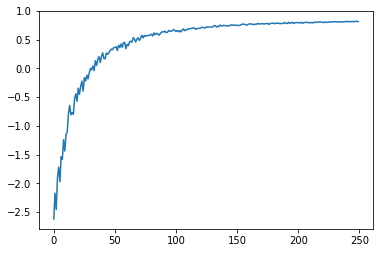

In [11]:
#This is the result without BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[64]*3, BatchNorm=False)
means = dqn(n_episode=250, HER=True)
plt.plot(means)
plt.show()

Episode 50, Score 0.2590	Average Score: -0.5041 
Episode 100, Score 0.6508	Average Score: 0.0152 
Episode 150, Score 0.7707	Average Score: 0.6244 
Episode 200, Score 0.8002	Average Score: 0.7458 
Episode 250, Score 0.8150	Average Score: 0.7918 


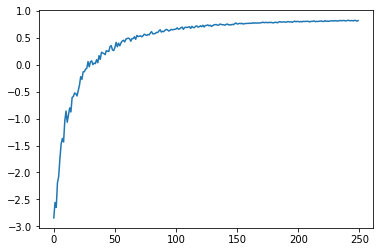

In [12]:
#This is the result without BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[64]*3, BatchNorm=False)
means = dqn(n_episode=250, HER=False)
plt.plot(means)
plt.show()

It seems that this task is very simple, all kinds of agents performs similarly.

Now we make it harder and check the result of $n=10$

In [13]:
env = test_environment(10, 10)
env.goal

array([[0., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 1., 1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 1.]])

Episode 50, Score -31.5786	Average Score: -38.9915 
Episode 100, Score -8.8341	Average Score: -33.1652 
Episode 150, Score 0.4177	Average Score: -13.7699 
Episode 200, Score 0.4990	Average Score: 0.1227 8
Episode 250, Score 0.5330	Average Score: 0.4806 
Episode 300, Score 0.5570	Average Score: 0.5345 
Episode 350, Score 0.5811	Average Score: 0.5637 
Episode 400, Score 0.5936	Average Score: 0.5783 
Episode 450, Score 0.5958	Average Score: 0.5864 
Episode 500, Score 0.5975	Average Score: 0.5913 


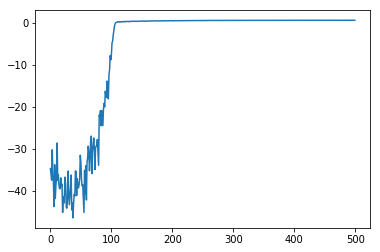

In [12]:
#With BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=True)
means = dqn(n_episode=500, HER=False)
plt.plot(means)
plt.show()

Episode 50, Score -1.9455	Average Score: -26.6624 
Episode 100, Score 0.0990	Average Score: -13.4975 
Episode 150, Score 0.4148	Average Score: -0.0277 
Episode 200, Score 0.5045	Average Score: 0.3613 
Episode 250, Score 0.5381	Average Score: 0.4804 
Episode 300, Score 0.5565	Average Score: 0.5346 
Episode 350, Score 0.5850	Average Score: 0.5632 
Episode 400, Score 0.5869	Average Score: 0.5782 
Episode 450, Score 0.5898	Average Score: 0.5867 
Episode 500, Score 0.5995	Average Score: 0.5917 


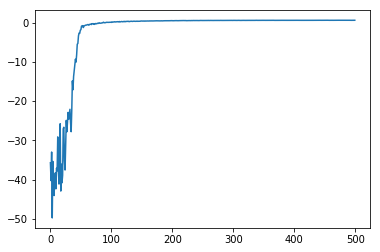

In [17]:
#Without BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=False)
means = dqn(n_episode=500, HER=False)
plt.plot(means)
plt.show()

Episode 50, Score -1.2797	Average Score: -14.5157 
Episode 100, Score 0.1103	Average Score: -7.4234 
Episode 150, Score 0.3788	Average Score: -0.0276 
Episode 200, Score 0.4871	Average Score: 0.3609 
Episode 250, Score 0.5551	Average Score: 0.4814 
Episode 300, Score 0.5597	Average Score: 0.5341 
Episode 350, Score 0.5699	Average Score: 0.5618 
Episode 400, Score 0.5893	Average Score: 0.5781 
Episode 450, Score 0.5930	Average Score: 0.5873 
Episode 500, Score 0.5950	Average Score: 0.5913 


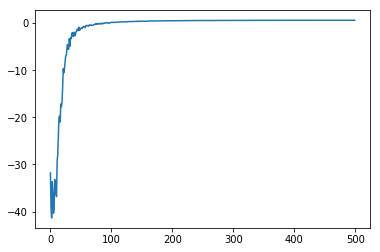

In [14]:
#With BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=True)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

Episode 50, Score -0.9854	Average Score: -11.4360 
Episode 100, Score 0.1634	Average Score: -5.8752 
Episode 150, Score 0.3653	Average Score: -0.0215 
Episode 200, Score 0.4936	Average Score: 0.3559 
Episode 250, Score 0.5574	Average Score: 0.4790 
Episode 300, Score 0.5587	Average Score: 0.5352 
Episode 350, Score 0.5699	Average Score: 0.5628 
Episode 400, Score 0.5812	Average Score: 0.5781 
Episode 450, Score 0.5987	Average Score: 0.5872 
Episode 500, Score 0.5882	Average Score: 0.5919 


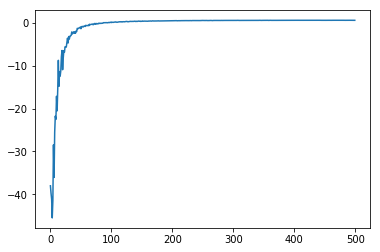

In [18]:
#Without BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=False)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

We can see as the task gets harder, the agents takes harder to learn to reach the goal. It seems that Batch normalization does not help the training, if not harms but HER greatly increase the learning speed.

In the next few blocks you will see that as task gets even harder ($n=15, 20$), agent cannot learning anything meaningful without the help of HER. Batch normalization on the other hand, does not help or harm much.

In [19]:
env = test_environment(10, 15)
env.goal

array([[1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.]])

Episode 50, Score -75.0000	Average Score: -73.6309 
Episode 100, Score -75.0000	Average Score: -74.0418 
Episode 150, Score -75.0000	Average Score: -74.4935 
Episode 200, Score -75.0000	Average Score: -74.4579 
Episode 250, Score -75.0000	Average Score: -74.6430 
Episode 300, Score -70.6600	Average Score: -74.7546 
Episode 350, Score -75.0000	Average Score: -74.7334 
Episode 400, Score -75.0000	Average Score: -74.8589 
Episode 450, Score -75.0000	Average Score: -74.9279 
Episode 500, Score -75.0000	Average Score: -74.9354 


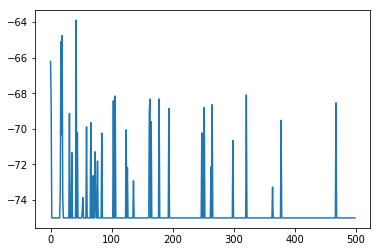

In [20]:
#With BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=True)
means = dqn(n_episode=500, HER=False)
plt.plot(means)
plt.show()

Episode 50, Score -75.0000	Average Score: -73.5869 
Episode 100, Score -75.0000	Average Score: -73.9016 
Episode 150, Score -75.0000	Average Score: -74.2022 
Episode 200, Score -75.0000	Average Score: -74.4953 
Episode 250, Score -75.0000	Average Score: -74.7606 
Episode 300, Score -75.0000	Average Score: -74.8594 
Episode 350, Score -75.0000	Average Score: -74.9381 
Episode 400, Score -75.0000	Average Score: -74.8388 
Episode 450, Score -75.0000	Average Score: -74.9007 
Episode 500, Score -75.0000	Average Score: -74.8766 


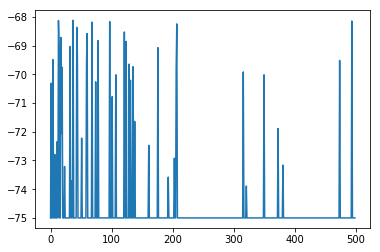

In [21]:
#Without BatchNorm, without HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=False)
means = dqn(n_episode=500, HER=False)
plt.plot(means)
plt.show()

Episode 50, Score -5.2245	Average Score: -54.4337 
Episode 100, Score -0.4775	Average Score: -27.9094 
Episode 150, Score 0.0029	Average Score: -0.7826 4
Episode 200, Score 0.1715	Average Score: -0.0366 
Episode 250, Score 0.2687	Average Score: 0.1639 
Episode 300, Score 0.2923	Average Score: 0.2480 
Episode 350, Score 0.3331	Average Score: 0.2913 
Episode 400, Score 0.3381	Average Score: 0.3166 
Episode 450, Score 0.3483	Average Score: 0.3305 
Episode 500, Score 0.3443	Average Score: 0.3372 


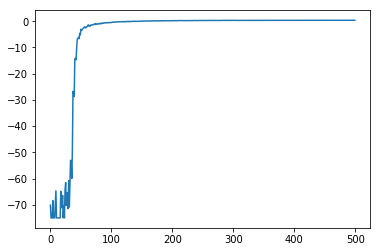

In [16]:
#With BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=True)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

Episode 50, Score -3.4752	Average Score: -40.5658 
Episode 100, Score -0.5042	Average Score: -20.9577 
Episode 150, Score 0.0105	Average Score: -0.7648 2
Episode 200, Score 0.1996	Average Score: -0.0378 
Episode 250, Score 0.2574	Average Score: 0.1628 
Episode 300, Score 0.2792	Average Score: 0.2481 
Episode 350, Score 0.3112	Average Score: 0.2912 
Episode 400, Score 0.3272	Average Score: 0.3168 
Episode 450, Score 0.3437	Average Score: 0.3310 
Episode 500, Score 0.3408	Average Score: 0.3372 


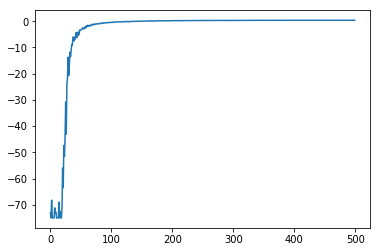

In [21]:
#Without BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=False)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

In [17]:
env = test_environment(10, 20)
env.goal

array([[1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 0.]])

Episode 50, Score -100.0000	Average Score: -99.9266 
Episode 100, Score -1.2747	Average Score: -65.8942 
Episode 150, Score -0.3922	Average Score: -16.3281 
Episode 200, Score -0.1609	Average Score: -0.5236 
Episode 250, Score -0.0523	Average Score: -0.1666 
Episode 300, Score 0.0339	Average Score: -0.0410 
Episode 350, Score 0.0574	Average Score: 0.0210 1
Episode 400, Score 0.0778	Average Score: 0.0556 
Episode 450, Score 0.0776	Average Score: 0.0729 
Episode 500, Score 0.0661	Average Score: 0.0813 


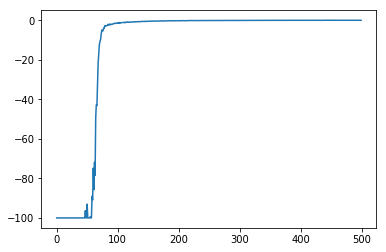

In [18]:
#With BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=True)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

Episode 50, Score -98.2100	Average Score: -98.6921 0
Episode 100, Score -1.2674	Average Score: -55.6194 
Episode 150, Score -0.3851	Average Score: -6.6467 
Episode 200, Score -0.1706	Average Score: -0.5008 
Episode 250, Score -0.0688	Average Score: -0.1669 
Episode 300, Score 0.0206	Average Score: -0.0384 
Episode 350, Score 0.0658	Average Score: 0.0232 
Episode 400, Score 0.0615	Average Score: 0.0560 
Episode 450, Score 0.0936	Average Score: 0.0743 
Episode 500, Score 0.0731	Average Score: 0.0825 


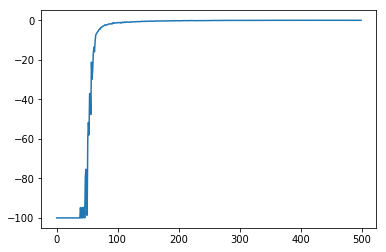

In [24]:
#Without BatchNorm, with HER
agent = DQN_Agent(env=env, state_size=env.length, action_size=env.length, seed=1, prioritized=False, Duel=False, fc_units=[128]*3, BatchNorm=False)
means = dqn(n_episode=500, HER=True)
plt.plot(means)
plt.show()

## Hindsights for PPO?

Now I am trying to extend hindsight replay to PPO methods. Although this is not mentioned in the original paper since PPO does not explicitly holds a replay buffer, it still has a temporary replay buffer for each episode. I think this guarantees that PPO can also take advantage of hindsight. I will update this when the experiments are finished.

In [ ]:
class Discrete_Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc_units=None, BatchNorm=False):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Discrete_Actor, self).__init__()
        if fc_units is None:
            fc_units = [256, 256, 256]
        self.fc1=nn.Linear(2*state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.bn1 = nn.BatchNorm1d(fc_units[0])
        self.bn2 = nn.BatchNorm1d(fc_units[1])
        self.bn3 = nn.BatchNorm1d(fc_units[2])
        self.output = nn.LogSoftmax(dim = 1)
        self.BatchNorm = BatchNorm

    def forward(self, state, goal):
        """Build a network that maps state -> action values."""
        x = torch.cat([state, goal], dim=1)
        if self.BatchNorm:
            x=self.bn1(F.relu(self.fc1(x)))
            x=self.bn2(F.relu(self.fc2(x)))
            x=self.bn3(F.relu(self.fc3(x)))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
        x=self.output(self.fc4(x))
        return(x)
    
class Critic(nn.Module):
    '''This critic does not consider action'''
    def __init__(self, state_size, hidden=None, BatchNorm=False):
        super(Critic, self).__init__()
        if hidden is None:
            hidden = [256, 256, 256]
        self.fc1 = nn.Linear(2*state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])
        self.fc4 = nn.Linear(hidden[2], 1)
        self.bn1 = nn.BatchNorm1d(hidden[0])
        self.bn2 = nn.BatchNorm1d(hidden[1])
        self.bn3 = nn.BatchNorm1d(hidden[2])
        self.BatchNorm = BatchNorm
        
    def forward(self, state, goal):
        x = torch.cat([state, goal], dim=1)
        if self.BatchNorm:
            x = self.bn1(F.relu(self.fc1(x)))
            x = self.bn2(F.relu(self.fc2(x)))
            x = self.bn3(F.relu(self.fc3(x)))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

Batch_Size = 128
GAMMA = 0.99            # discount factor for reward
TAU = 0.95              # discount factor for advantage
Beta = 0                # Coefficient for KL divergence
LR1 = 1e-4              # learning rate 
LR2 = 1e-4              # learning rate 
Eps = 0.1               # torelated error of ratio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, lr1=LR1, lr2=LR2, gamma=GAMMA, tau=TAU, beta=Beta, eps=Eps, method='MC', learning_time=4, fc_units=None, BatchNorm=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            lr1/lr2 (float): learning rate for actor/critic
            tau (float): decay rate for advantage function
            gamma (float): decay rate for future rewards
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr1 = lr1
        self.lr2 = lr2
        self.gamma = gamma
        self.tau = tau
        self.beta = beta
        self.batch_size = Batch_Size
        self.eps = eps
        
        self.actor = Discrete_Actor(state_size, action_size, fc_units, BatchNorm=BatchNorm).to(device)
        self.critic = Critic(state_size, hidden=fc_units, BatchNorm=BatchNorm).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr1)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr2)
        if method in ['MC', 'TD']:
            self.method = method
        else:
            print('Only support MC or TD method. Input not supported. Use MC by default')
            self.method = 'MC'
        
        self.learn_time = learning_time # How many updates for each episode

    def act(self, state, goal):
        """
        Returns actions' probabilities for given state as per current policy.
        Also saves the history for later update.
        
        Inputs:
        ==========================
        state(float): the current state, which is a tensor
        """
        self.actor.eval()
        self.critic.eval()
        log_probs = self.actor(state, goal)
        values = self.critic(state, goal)
        self.actor.train()
        self.critic.train()
        return log_probs, values

    def learn(self, states, goals, actions, log_probs, advantages, returns):
        """Update value parameters using the memory of current episode"""
        
        mydata = TensorDataset(states.detach(), goals.detach(), actions.detach(), log_probs.detach(), advantages.detach(), returns.detach())
        Loader = DataLoader(mydata, batch_size = self.batch_size, shuffle = True)
        
        for _ in range(self.learn_time):
            for sampled_states, sampled_goals, sampled_actions, sampled_log_probs, sampled_advantages, sampled_returns in iter(Loader):
                batch_number += 1
                sampled_actions = sampled_actions.long()
                new_log_probs, _ = self.act(sampled_states, sampled_goals)
                ratio = (new_log_probs - sampled_log_probs).exp().gather(1, sampled_actions)
                KL = -new_log_probs.exp()*(new_log_probs - sampled_log_probs)
                KL = torch.sum(KL, dim=1, keepdim=True)
                
                estimated_values = self.critic(sampled_states, sampled_goals)
                
                Actor_Loss = -torch.min(input=ratio*sampled_advantages, other=torch.clamp(ratio, 1-self.eps, 1+self.eps)*sampled_advantages).mean()
                Actor_Loss -= self.beta*KL.mean()
                if torch.isnan(Actor_Loss):
                    None
                else:
                    self.actor_optimizer.zero_grad()
                    Actor_Loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)
                    self.actor_optimizer.step()
                
                Critic_Loss = 0.5*(estimated_values - sampled_returns).pow(2).mean()
                if torch.isnan(Critic_Loss):
                    None
                else:
                    self.critic_optimizer.zero_grad()
                    Critic_Loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
                    self.critic_optimizer.step() 

In [ ]:
def PPO_Discrete(n_episodes, max_t, agent, env, HER=True):
    """
    Monitor the training process
    Params
    ======
        env, brain_name and agent are assumed to be defined elsewhere
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        UPDATE (int): number of episodes before each update
    """
    scores_window = deque(maxlen=100)  # last 100 scores
    means = []
    state_history = []
    goal_history = []
    action_history = []
    values_history = []
    reward_history = []
    log_prob_history = []
    done_history = []
    for i_episode in range(1, n_episodes+1):
            
        env_info = env.reset()
        episodic_rewards = []
        state = env_info.vector_observations.copy()
        goal = env.goal.copy()
        score = np.zeros((env.num_agents,1))
        for t in range(1, max_t+1):
            log_probs, values = agent.act(torch.tensor(state, dtype=torch.float32).to(device),
                                          torch.tensor(goal, dtype=torch.float32).to(device))
            probs = np.exp(log_probs.detach().numpy())
            action = np.zeros(env.num_agents)
            for j in range(env.num_agents):
                action[j] = np.random.choice(a=agent.action_size, size=1, replace=False, p=probs[j,:])
            action = np.array(action, dtype=int)
            env_info = env.step(action)
            next_state = env_info.vector_observations.copy()
            next_goal = env.goal.copy()
            reward = env_info.rewards.copy()
            done = env_info.local_done.copy()
            
            state_history.append(torch.tensor(state, dtype=torch.float32).to(device))
            goal_history.append(torch.tensor(goal, dtype=torch.float32).to(device))
            action_history.append(torch.tensor(action, dtype=torch.int8).to(device))
            values_history.append(torch.tensor(values.detach(), dtype=torch.float32).to(device))
            reward_history.append(torch.tensor(reward, dtype=torch.float32).to(device))
            log_prob_history.append(log_probs)
            done_history.append(torch.tensor(done.astype(float), dtype=torch.float32).to(device))
            
            state = next_state.copy()
            goal = next_goal.copy()
            score += reward.copy()
            
            for j in range(env.num_agents):
                if done[j]:
                    episodic_rewards.append(score[j].copy())
                    score[j] = 0
                
        scores_window.append(np.mean(episodic_rewards))       # save most recent score
        means.append(np.mean(episodic_rewards))              # save most recent score
        print('\rEpisode {}\tEpisodic Score: {:.4f}\tAverage Score: {:.4f}'.format(i_episode, means[-1], np.mean(scores_window),), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisodic Score: {:.4f}\tAverage Score: {:.4f}'.format(i_episode, means[-1], np.mean(scores_window)))
        
        if True:
            state_history.append(torch.tensor(state, dtype=torch.float32).to(device))
            goal_history.append(torch.tensor(goal, dtype=torch.float32).to(device))
            _, values = agent.act(torch.tensor(state, dtype=torch.float32).to(device),
                                  torch.tensor(goal, dtype=torch.float32).to(device))
            values_history.append(torch.tensor(values.detach(), dtype=torch.float32).to(device))
            Advantages = [] #Save advantages to update actor
            advantages = 0
            Returns = [] #Save returns to update critic
            returns = 0
            for i in reversed(range(len(state_history)-1)):
                state = state_history[i]
                next_state = state_history[i+1]
                goal = goal_history[i]
                next_goal = state_history[i+1]
                values = values_history[i]
                next_values = values_history[i+1]
                if agent.method == 'MC':
                    returns = (1-done_history[i])*agent.gamma*returns + reward_history[i]
                else:
                    returns = (1-done_history[i])*agent.gamma*next_values + reward_history[i]
                Returns.append(returns.detach())
                delta = reward_history[i]+(1-done_history[i])*agent.gamma*next_values-values
                advantages = (1-done_history[i])*agent.gamma*agent.tau*advantages + delta
                Advantages.append(advantages.detach().view(-1))
        
            Advantages.reverse()
            Advantages = torch.stack(Advantages).detach().to(device)
            Advantages = (Advantages - Advantages.mean(dim=1 ,keepdim=True))/Advantages.std(dim=1, keepdim=True)
            Advantages = Advantages.view(-1,1)
            Returns.reverse()
            Returns = torch.stack(Returns).detach().to(device)
            Returns = Returns.view(-1,1)
            states = torch.cat(state_history[:-1], 0)
            goals = torch.cat(goal_history[:-1], 0)
            actions = torch.cat(action_history, 0).view(-1, 1)
            log_probs = torch.cat(log_prob_history, 0)
            
            agent.learn(states, goals, actions, log_probs, Advantages, Returns)
            
            state_history = []
            goal_history = []
            action_history = []
            reward_history = []
            log_prob_history = []
            done_history = []
        
        for actor_param, critic_param in zip(agent.actor.parameters(), agent.critic.parameters()):
            if any(torch.isnan(actor_param.view(-1))) or any(torch.isnan(critic_param.view(-1))):
                print('Nan in weights!')
        
    torch.save(agent.actor.state_dict(), 'PPO_{}_checkpoint.pth'.format(agent.method))
    return means

In [ ]:
env = test_environment(10, 5)
agent = PPO_Agent(env=env, state_size=env.length, action_size=env.length, fc_units=[32]*3, BatchNorm=False)
means = PPO_Discrete(n_episode=250, max_t=1000, agent=agent, env=env, BatchNorm=True)
plt.plot(means)
plt.show()